# Figure 3: Spliced leader usage frequency

**Summary:**<br>

This notebook compiles the scripts that were used to generate the Figure 3.

- **Panel a:** Spliced leader usage

- **Panel b:** SL2 gene specificity


---
<br>



## Import libraries

In [1]:

import pandas as pd
import numpy as np

import seaborn as sns
import scipy
import re

from itertools import tee

import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

## Settings for saving figures as pdf

In [2]:
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

## Set environmental constants

In [ ]:
# Set path where files are stored
path = '/Volumes/elegans/rna_sequencing'

## Opening Dataset file

In [3]:
# Open dataset generated as part of the pre-processing step
dataset = pd.read_csv(f'{path}/dataset_+SSP+SL+HAIRPIN.tsv', sep='\t')

----

In [4]:
# We removed sense reads obtained in the SL1_1 experiment in order to not count "SL1 reads" 
# that would result from the hybridization of the SL1 primer on a SL2 or random sequence during 2nd strand synthesis

data = pd.concat([dataset[(dataset['run'] != 'SL1_1')], 
                  dataset[(dataset['run'] == 'SL1_1') & (dataset['read_orientation'] == 'antisense')]])

<br>

# Panel a: Spliced Leader usage

In [5]:
rows = []

# loop over gene
for gene, reads in data.groupby('gene'):
    
    # loop over start positions
    for start, subreads in reads.groupby('corrected_genomic_start'):
        
        total = len(subreads)
        robust_sl = subreads[subreads['VARIANT_SL_FOUND']=='FOUND']
        robust = len(robust_sl)
        
        # if robust SL reads at the observed position
        if robust > 0:
            sl1 = len(robust_sl[robust_sl['SL'].str.contains('SL1')])
            sl2 = len(robust_sl[~robust_sl['SL'].str.contains('SL1')])
            ratio = round(sl2/(sl1+sl2)*100, 2)
            
            
            row = { 'gene': gene, 'start':start, 'total':total, 'robust':robust,
                    'SL1':sl1,'SL2':sl2,'SL_ratio':ratio}
            
            rows.append(row)

# create dataframe based on lists
start_pos = pd.DataFrame(rows)

# save
start_pos.to_csv('Fig3.a-SL2_ratio_per_gene.tsv', sep='\t', index=None)

In [6]:
# for each gene, we considered the most expressed start position as the main trans-splicing position
# for multiple positions with same amount of reads, the number of robust reads is determinant   
main_start_pos = start_pos.sort_values(['total', 'robust'], ascending=False).groupby('gene').head(1)

In [7]:
# Function used to create pairs of successive values : (A,B) (B,C) (C,D) (D,E) etc...

def pairwise(iterable):
    
    a, b = tee(iterable)
    next(b, None)
    return zip(a, b)


# function to measure distance between two genes

def compute_distance(orientation, up_gene_end, down_gene_start):
    
    if orientation == '+':
        
        if down_gene_start < up_gene_end:
            dist = -1
        else:
            dist = abs(down_gene_start - up_gene_end)
            
    else:
        if down_gene_start > up_gene_end:
            dist = -1
        else:
            dist = abs(down_gene_start - up_gene_end)
    
    return dist

In [8]:
# open reference file for gene coordinates
coordinates = pd.read_csv(f'{path}/ref/prot_coding_gene_location.tsv', sep='\t', 
                          names=['wormbaseID','gene','name','strand','chromosome','start','end'])

# separate gene on (+) and (-) strand 
plus = coordinates[coordinates['strand']==1]
minus = coordinates[coordinates['strand']==-1]

# correctly label 'start' coordinates for genes on (-) strand 
_map = {'start':'end', 'end':'start'}
minus.columns = [{**_map, **{v:k for k,v in _map.items()}}.get(x, x) for x in minus.columns]

# reassemble tabs
coordinates = pd.concat([plus, minus])

# Generate pairs of genes (upstream -> downstream) based on genomic coordinates

up = []
down = []
up_end = []
orientation = []

for (ch,std), table in coordinates.groupby(['chromosome','strand']):
    
    if std == 1:
        
        table = table.sort_values('start', ascending=True)
        
        for (i1, row1), (i2, row2) in pairwise(table.iterrows()):
            up.append(row1["gene"])
            up_end.append(row1["end"])
            down.append(row2["gene"])
            orientation.append('+')
            
    if std == -1:
        
        table = table.sort_values('end', ascending=False)
        
        for (i1, row1), (i2, row2) in pairwise(table.iterrows()):
            
            up.append(row1["gene"])
            up_end.append(row1["end"])
            down.append(row2["gene"])
            orientation.append('-')
            

###### CREATE DATAFRAME
gene_pairs = pd.DataFrame(dict(upstream_gene=up, upstream_end=up_end, downstream_gene=down,  sens=orientation))

###### ADD COLUMNS

# create dict and then map
main_start_pos = start_pos.sort_values('total', ascending=False).groupby('gene').head(1)
main_start_pos = main_start_pos.set_index('gene')

# downstream gene start pos
main_start_pos['start'] = main_start_pos['start'].astype(int)
start = main_start_pos['start'].to_dict()
gene_pairs['downstream_start'] = gene_pairs['downstream_gene'].map(start)

# downstream gene SL ratio
slratio = main_start_pos['SL_ratio'].to_dict()
gene_pairs['downstream_SLratio'] = gene_pairs['downstream_gene'].map(slratio)
gene_pairs['upstream_SLratio'] = gene_pairs['upstream_gene'].map(slratio)

# downstream total reads
total = main_start_pos['total'].to_dict()
gene_pairs['downstream_reads'] = gene_pairs['downstream_gene'].map(total)

# downstream gene robust SL reads
robust = main_start_pos['robust'].to_dict()
gene_pairs['downstream_robust'] = gene_pairs['downstream_gene'].map(robust)

# upstream total reads
gene_expression = start_pos.set_index('gene')['total'].to_dict()
gene_pairs['upstream_reads'] = gene_pairs['upstream_gene'].map(gene_expression)
gene_pairs['upstream_reads'] = gene_pairs['upstream_reads'].fillna(0)

# add distance between end of upstream gene and start of downstream gene
gene_pairs['distance'] = gene_pairs.apply(lambda x: compute_distance(x['sens'], x['upstream_end'], x['downstream_start']), axis=1)


#### CLEAN TABLE

# only keep rows where we have data for both gene in the pair
gene_pairs = gene_pairs[(gene_pairs['upstream_end'].notna()) & (gene_pairs['downstream_start'].notna())]

# convert floats to int
gene_pairs['downstream_start'] = gene_pairs['downstream_start'].astype(int)

# reorder columns
gene_pairs = gene_pairs[['upstream_gene','upstream_end','upstream_reads','upstream_SLratio',
                         'downstream_gene','downstream_start','downstream_reads','downstream_robust','downstream_SLratio',
                         'sens','distance']]

# save table
gene_pairs.to_csv('Fig3.a-gene_pairs.tsv', index=None, sep='\t')

In [9]:
# nb of peak positions with SL2 ratio > 60% 
nb_sl2_pos = len(gene_pairs[(gene_pairs['downstream_SLratio']>=60)]['downstream_gene'])
print(f'number of start positions preferentially SL2: {nb_sl2_pos}')

# nb of peak positions with SL2 ratio < 40% 
nb_sl1_pos = len(gene_pairs[(gene_pairs['downstream_SLratio']<=40)]['downstream_gene'])
print(f'number of start positions preferentially SL1: {nb_sl1_pos}')


number of start positions preferentially SL2: 2496
number of start positions preferentially SL1: 8455


In [10]:
# select only genes for which we have a minimum of 10 robust reads in order to measure SL ratio
subdata = gene_pairs[gene_pairs['downstream_robust'] >= 10]
sl2_data = subdata[subdata['downstream_SLratio'] >= 60]
sl1_data = subdata[subdata['downstream_SLratio'] <= 40]

In [11]:
# Count number of SL1 and SL2 genes showed on plot (bottom panel)
not_sl1 = subdata[subdata['downstream_SLratio'] > 40]
not_sl1_sl2 = not_sl1[not_sl1['downstream_SLratio'] < 60]

sl1_genes = len(sl1_data)
print(f'Number of SL1 genes (ratio less than 40%): {sl1_genes}')

sl2_genes = len(sl2_data)
print(f'Number of SL2 genes (ratio more than 60%): {sl2_genes}')

slx_genes = len(not_sl1_sl2)
print(f'Number of SLX genes (ratio between 40 and 60%): {slx_genes}')

Number of SL1 genes (ratio less than 40%): 3780
Number of SL2 genes (ratio more than 60%): 1008
Number of SLX genes (ratio between 40 and 60%): 73


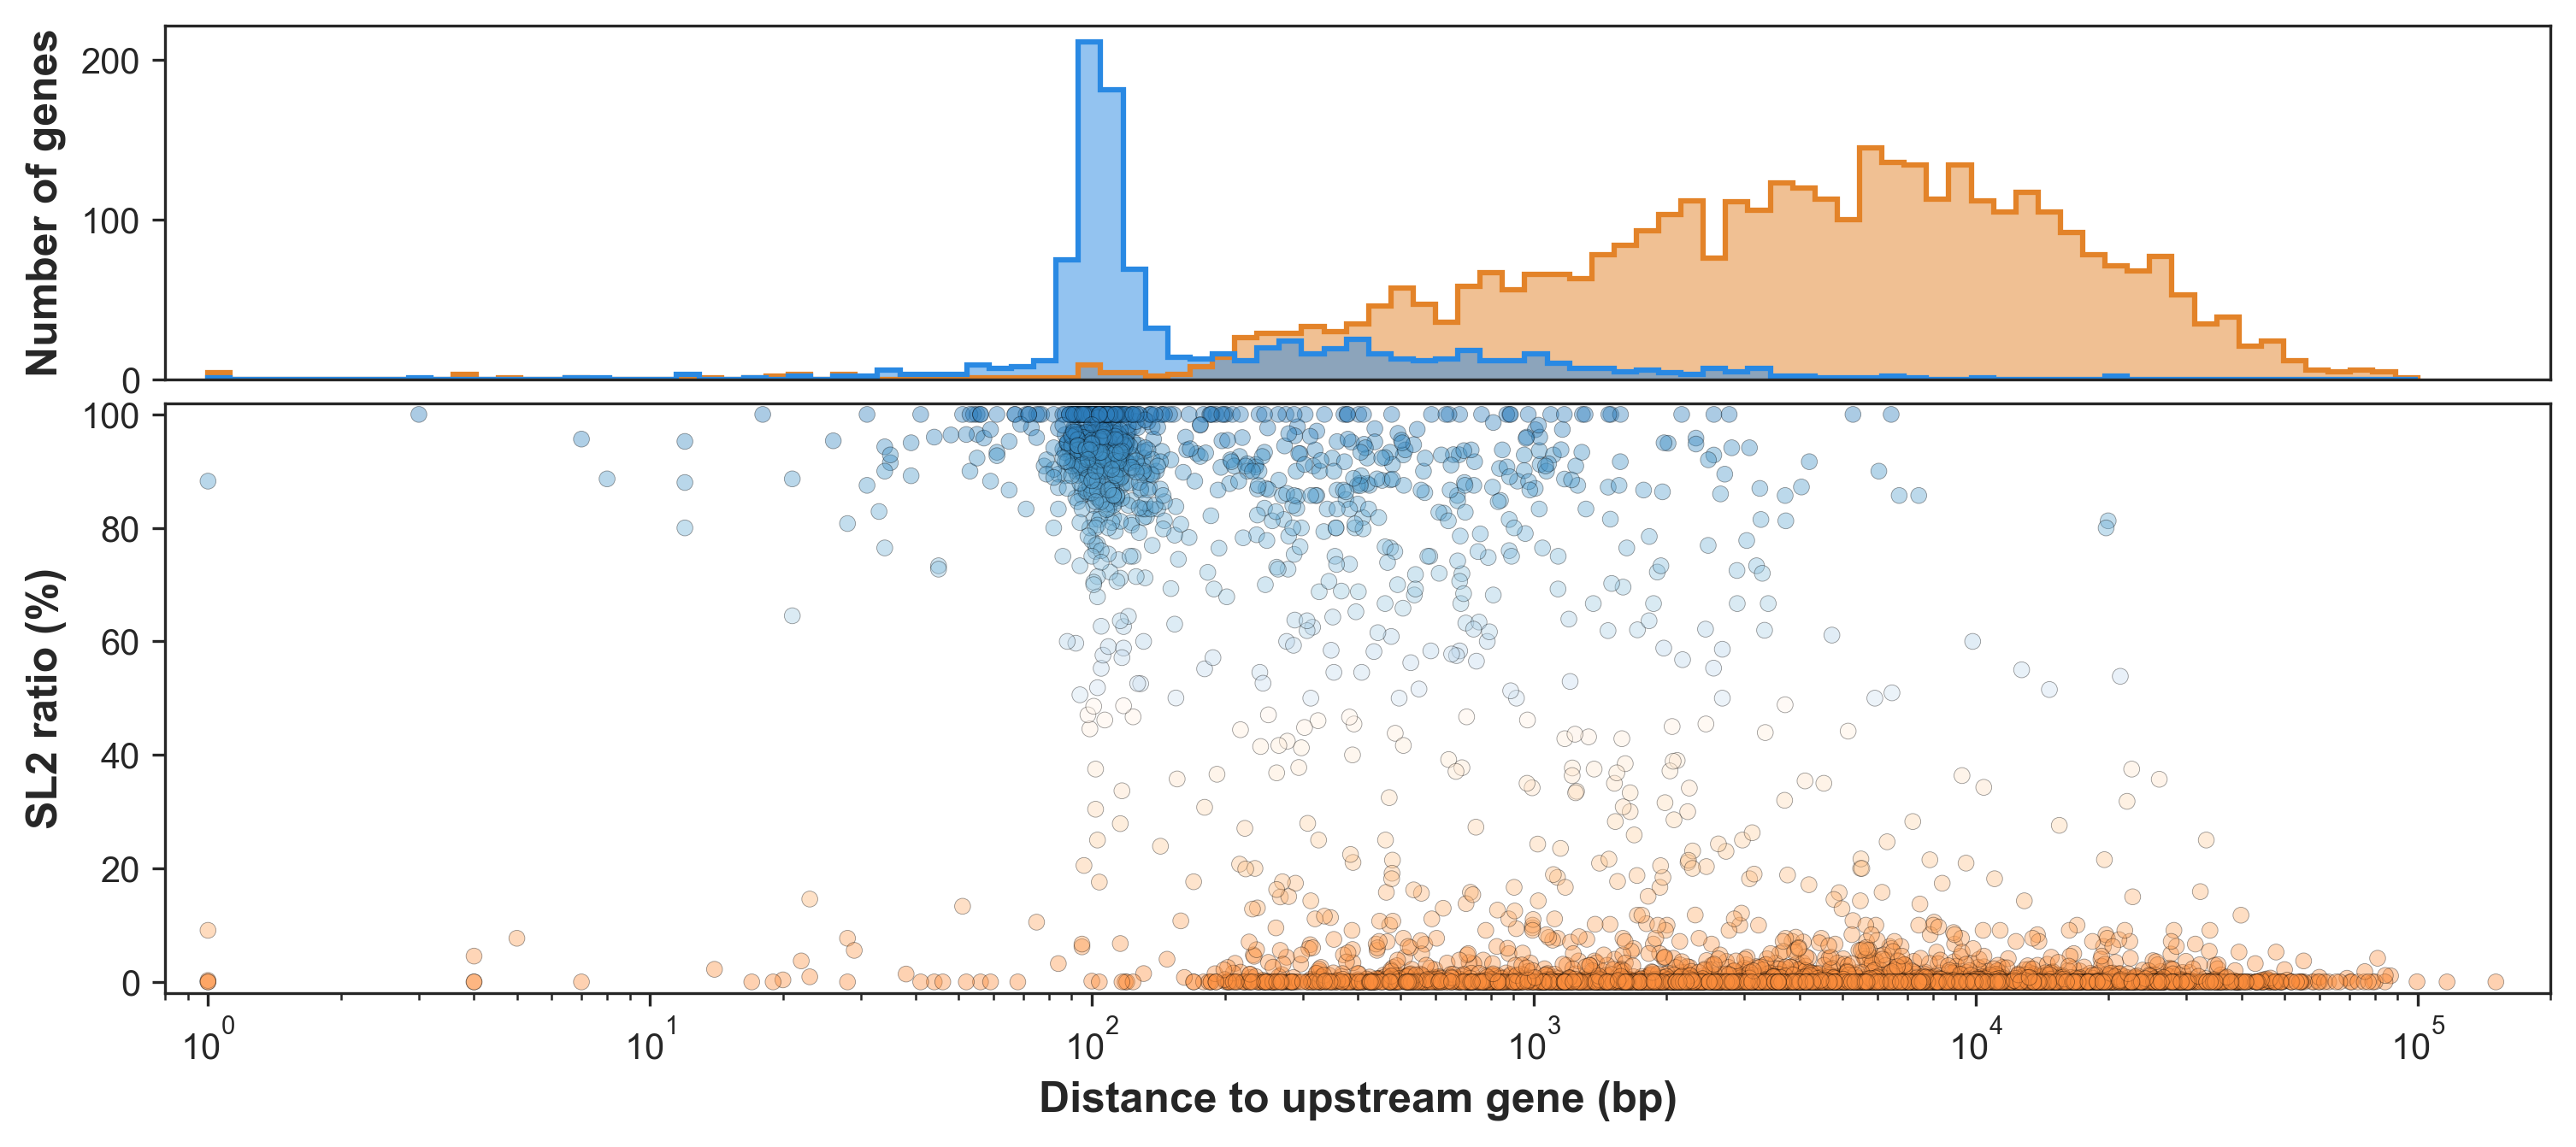

In [12]:
%matplotlib inline

# initialize plot
sns.set_style('ticks')
fig, ax = plt.subplots(figsize=(12,5), dpi=300, nrows=2, ncols=1, sharex=True, gridspec_kw={'height_ratios': [3, 5]})

# Select gene with at least 10 SL robust reads and split into SL1 and SL2 groups based on ratio
MIN, MAX = 1, 10**5

# create custom colormap
top = cm.get_cmap('Oranges_r', 128)
bottom = cm.get_cmap('Blues', 128)
newcolors = np.vstack((top(np.linspace(0.5, 1, 128)), bottom(np.linspace(0.2, 0.7, 128))))
newcmp = ListedColormap(newcolors, name='OrangeBlue')

# plot TOP panel (distribution)
sl1_data['distance'].hist(histtype='stepfilled', linewidth=0, color='#e38329', bins=10 ** np.linspace(np.log10(MIN), np.log10(MAX), 100), alpha=0.5, ax=ax[0])
sl1_data['distance'].hist(histtype='step', linewidth=1.5, color='#e38329', bins=10 ** np.linspace(np.log10(MIN), np.log10(MAX), 100), alpha=1, ax=ax[0])
sl2_data['distance'].hist(histtype='stepfilled', linewidth=0, color='#2989e3',bins=10 ** np.linspace(np.log10(MIN), np.log10(MAX), 100), alpha= 0.5, ax=ax[0])
sl2_data['distance'].hist(histtype='step', linewidth=1.5, color='#2989e3',bins=10 ** np.linspace(np.log10(MIN), np.log10(MAX), 100), alpha=1, ax=ax[0])

# settings
ax[0].set_ylabel('Number of genes', weight='bold', size=12)
ax[0].set_xscale('log')
ax[0].set_xlim(left=0.5, right=10**5)
ax[0].grid(False)
ax[0].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax[0].tick_params(axis='y', which='both', left=True)

# plot BOTTOM panel (scatter plot)
ax[1].scatter(subdata['distance'], subdata['downstream_SLratio'], s=20, c=subdata['downstream_SLratio'], cmap=newcmp, edgecolor='k', linewidth=0.2, alpha=0.4)

# settings
ax[1].set_xscale('log')
ax[1].set_ylim(bottom=-2, top=102)
ax[1].set_xlim(left=0.8, right=2*10**5)
ax[1].set_xlabel("Distance to upstream gene (bp)", weight='bold', size=12)
ax[1].set_ylabel('SL2 ratio (%)', weight='bold', size=12)

# general subplots settings
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=.05)

# save as png
plt.savefig('Fig3.a-spliced_leader_usage.png', dpi=800, bbox_inches='tight')

<font size="4">**Figure 3.a:**<br></font>
**Bottom:** A scatter-plot of the ratio of SL2/SL1 reads found against the distance to the closest upstream gene. Position with at least a 60% bias are colored red for SL2 and blue for SL1. **Top:** Distribution SL1 and SL2 biased positions confirms previous observations of a strong preference for SL2 splicing to occur at a distance of ~100 nt downstream from the previous exon. 

<br>

<br>

# Panel b: SL2 gene specificity

In [13]:
# store each main start position in a dictionnary
_main = main_start_pos['start'].to_dict()

## Select only SL2 genes and count only SL2 variants
_sl2genes = list(sl2_data['downstream_gene'])
_data = data[data['gene'].isin(_sl2genes)]

# get robust variants
robust_sl = _data[_data['VARIANT_SL_FOUND']=='FOUND']

# create dataframe
gene_sl_count = pd.DataFrame()

# groupby gene
for (gene, start), reads in robust_sl.groupby(['gene','corrected_genomic_start']):
    
    if start == _main[gene]:
    
        # perfom value counts of SL founds associated with that gene
        _counts = pd.DataFrame(reads['SL'].value_counts())

        # initialize
        gene_sl_count.loc[gene,'total'] = 0
        gene_sl_count.loc[gene,'SL2_total'] = 0
        gene_sl_count.loc[gene,'SL1'] = 0
        gene_sl_count.loc[gene,'SL2.X'] = 0

        for SL, row in _counts.iterrows():
            
            # Total reads
            gene_sl_count.loc[gene,'total'] = gene_sl_count.loc[gene,'total'] + row['SL']

            # SL1 or SLX
            if 'SL1' in SL:
                gene_sl_count.loc[gene,'SL1'] = gene_sl_count.loc[gene,'SL1'] + row['SL']

            # SL2
            else:
                # Total SL2 variants
                gene_sl_count.loc[gene,'SL2_total'] = gene_sl_count.loc[gene,'SL2_total'] + row['SL']

                # SL2.X
                if '/' in SL:
                    gene_sl_count.loc[gene,'SL2.X'] = gene_sl_count.loc[gene,'SL2.X'] + row['SL']

                # SL2 variant   
                else:
                    gene_sl_count.loc[gene, SL] = row['SL']


# replace NaN with 0                
gene_sl_count = gene_sl_count.fillna(0)

# change col type from float to int
gene_sl_count = gene_sl_count.astype(int)

# reorder columns 
order = ['total', 'SL1', 'SL2_total','SL2.X','SL2.1','SL2.5','SL2.8','SL2.9','SL2.10','SL2.12','SL2.14','SL2.15','SL2.16','SL2.17','SL2.18']
gene_sl_count = gene_sl_count[order]

# reorder rows based on expression level (highest to lowest)
gene_sl_count = gene_sl_count.sort_values('total', ascending=False)


In [14]:
gene_sl_count

,total,SL1,SL2_total,SL2.X,SL2.1,SL2.5,SL2.8,SL2.9,SL2.10,SL2.12,SL2.14,SL2.15,SL2.16,SL2.17,SL2.18
C53H9.1,9048,3382,5666,665,1166,634,957,229,261,159,369,263,307,79,577
T01C3.6,7615,1278,6337,846,1546,597,837,273,224,164,764,271,338,158,319
Y37E3.7,6046,33,6013,568,1534,783,932,271,183,293,302,289,356,215,287
F25H2.11,4221,292,3929,788,1207,316,488,198,145,148,92,120,159,85,183
F44E5.1,2237,302,1935,210,479,267,295,149,85,57,63,71,115,58,86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
F02E9.10,10,0,10,0,2,0,3,0,0,0,1,0,1,1,2
T13H5.8,10,0,10,1,2,1,2,0,0,0,1,2,1,0,0
T14G10.7,10,0,10,3,2,0,3,0,0,0,0,1,0,0,1
F52H3.2,10,1,9,3,2,1,1,0,1,0,0,0,0,1,0


In [15]:
# convert to percentage

gene_sl_percent = pd.DataFrame()

for col in gene_sl_count:
    if col not in ['total','SLX','SL1','SL2_total']:
        gene_sl_percent[col] = round(gene_sl_count[col]/gene_sl_count['SL2_total']*100, 2)

In [16]:
# main dataframe for plotting (only SL columns)
sl2 = gene_sl_percent.loc[:,'SL2.1':]

# intermediary dataframe for selecting genes based on their distance to the upstream gene
genes_dist = pd.DataFrame(sl2.index).set_index(0)
genes_dist.index.name = 'gene'

# add distance to upstream gene and filter in two catgeories:
# within operon (<200nt) and outside operon (>200nt)
_dist = gene_pairs.set_index('downstream_gene')['distance'].to_dict()
genes_dist['dist'] = genes_dist.index.map(_dist)
genes_dist['peak'] = genes_dist['dist'].apply(lambda x: 'within operon' if x <= 200 else 'outside operon')

In [17]:
# export SL2 table as .tsv

tsv_sl2 = gene_sl_count.copy()
tsv_sl2['dist'] = tsv_sl2.index.map(_dist).astype(int)

tsv_sl2.index.name = 'gene'
tsv_sl2 = tsv_sl2.reset_index()

tsv_sl2.to_csv('Fig3.b-SL2_main_start_positions.tsv', sep='\t', index=None)

<br>

## SL2 genes - within operon distance (200nt or less)

In [18]:
# names of genes not in peak
in_list = list(genes_dist[genes_dist['peak']=='within operon'].index)
# selection
_in = sl2[sl2.index.isin(in_list)]

print(f'Preferentially SL2 - within operon : {len(_in)} genes') 

Preferentially SL2 - within operon : 698 genes


<Figure size 3000x2000 with 0 Axes>

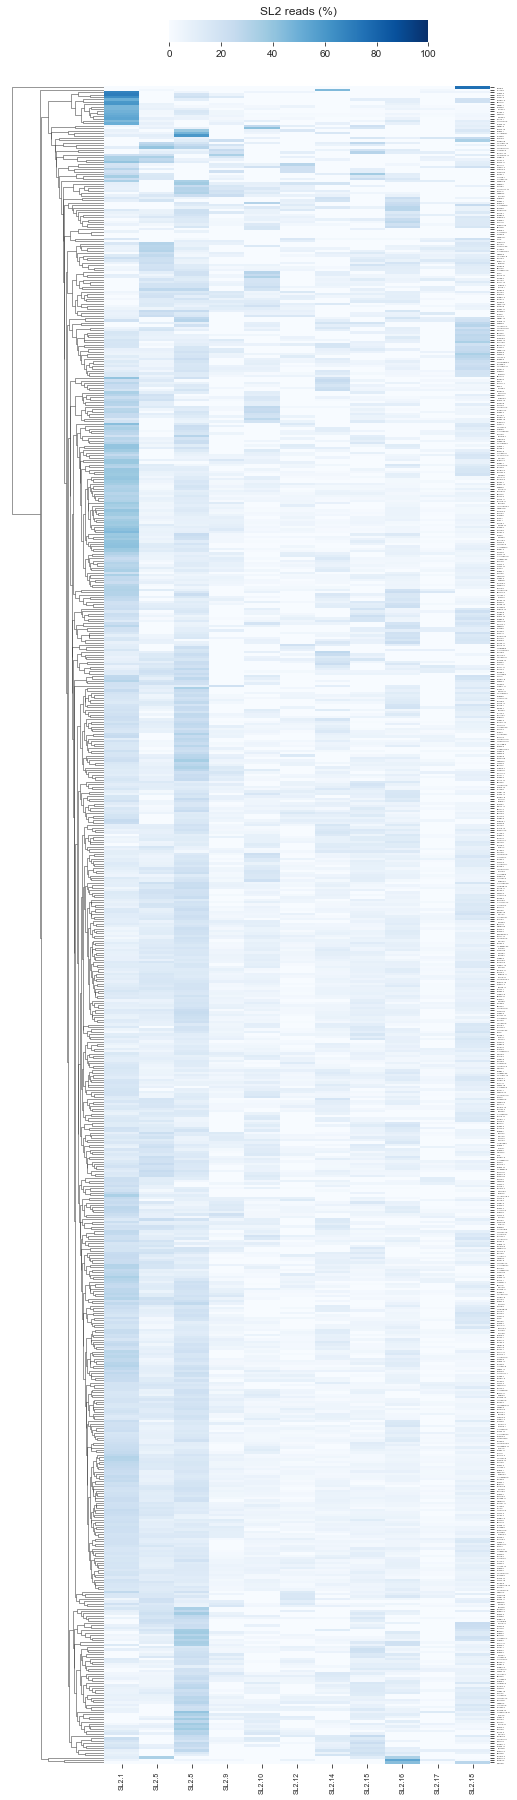

In [19]:
# initialize plot
%matplotlib inline
plt.figure(dpi=500)

# color palette
_map = sns.color_palette("Blues", as_cmap=True)

# generate clustermap
cluster = sns.clustermap(_in, vmin=0, vmax=100, cmap=_map, figsize=(8,30), dendrogram_ratio=0.2, 
                         yticklabels=True, xticklabels=True, col_cluster=False, 
                         cbar_kws={'orientation':'horizontal'}, cbar_pos=[0.3, 0.82, 0.45, 0.01])

# plot settings
_yticks = cluster.ax_heatmap.set_yticklabels(cluster.ax_heatmap.get_ymajorticklabels(), fontsize = 2)
_xticks = cluster.ax_heatmap.set_xticklabels(cluster.ax_heatmap.get_xmajorticklabels(), fontsize = 7)
cluster.ax_cbar.set_title('SL2 reads (%)', fontsize=12)
cluster.ax_col_dendrogram.set_visible(False)

# save
plt.savefig('Fig3.b-clustermap_SL2_within_operon.pdf',dpi=800, bbox_inches='tight')

<font size="4">**Figure 3.b:**<br></font>
For SL2 trans spliced site represented in panel a (with more than 10 individual reads with an unambiguous SL2 sequence) we represent the frequency of usage of each SL2. 

**SL2 genes - within operon:** genes identified as preferentially SL2 and located at 200nt or less from their nearest upstream coding gene.

<br>

## SL2 genes - Outside operon

In [20]:
# select SL2 genes outside operon
out_list = list(genes_dist[genes_dist['peak']=='outside operon'].index)
_out = sl2[sl2.index.isin(out_list)]

print(f'Preferentially SL2 - outside operon : {len(_out)} genes') 

Preferentially SL2 - outside operon : 310 genes


<Figure size 3000x2000 with 0 Axes>

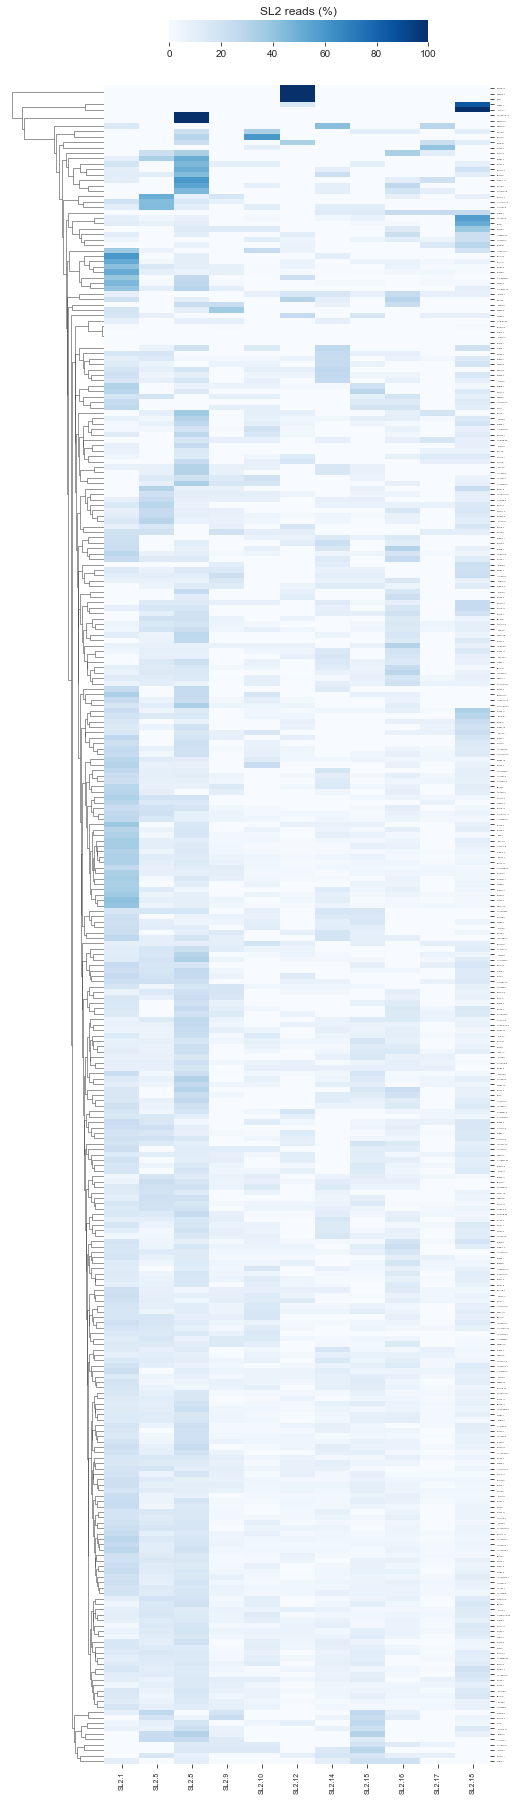

In [21]:
# initialize plot
%matplotlib inline
plt.figure(dpi=500)

# color palette
_map = sns.color_palette("Blues", as_cmap=True)

# generate clustermap
cluster = sns.clustermap(_out, vmin=0, vmax=100, cmap=_map, figsize=(8,30), dendrogram_ratio=0.2, 
                         yticklabels=True, xticklabels=True, col_cluster=False, 
                         cbar_kws={'orientation':'horizontal'}, cbar_pos=[0.3, 0.82, 0.45, 0.01])

# plot settings
_yticks = cluster.ax_heatmap.set_yticklabels(cluster.ax_heatmap.get_ymajorticklabels(), fontsize = 2)
_xticks = cluster.ax_heatmap.set_xticklabels(cluster.ax_heatmap.get_xmajorticklabels(), fontsize = 7)
cluster.ax_cbar.set_title('SL2 reads (%)', fontsize=12)
cluster.ax_col_dendrogram.set_visible(False)

# save
plt.savefig('Fig3.b-clustermap_SL2_outside_operon.pdf',dpi=800, bbox_inches='tight')

<font size="4">**Figure 3.b:**<br></font>
For SL2 trans spliced site represented in panel a (with more than 10 individual reads with an unambiguous SL2 sequence) we represent the frequency of usage of each SL2.<br>
**SL2 genes - outside operon:** genes identified as preferentially SL2 and located at more than 200nt from their nearest upstream coding gene.

<br>

## SL1 genes

In [22]:
## Select only SL1 genes
_sl1genes = list(sl1_data['downstream_gene'])
_data = data[data['gene'].isin(_sl1genes)]

# get robust SL
robust_sl = _data[_data['VARIANT_SL_FOUND']=='FOUND']

# create dataframe
sl1_table = pd.DataFrame()

# groupby gene
for (gene, start), reads in robust_sl.groupby(['gene','corrected_genomic_start']):
    
    if start == _main[gene]:
    
        # perfom value counts of SL founds associated with that gene
        _counts = pd.DataFrame(reads['SL'].value_counts())

        # initialize
        sl1_table.loc[gene,'total'] = 0
        sl1_table.loc[gene,'SL2_total'] = 0
        sl1_table.loc[gene,'SL1'] = 0
        sl1_table.loc[gene,'SL2.X'] = 0

        for SL, row in _counts.iterrows():

            sl1_table.loc[gene,'total'] = sl1_table.loc[gene,'total'] + row['SL']

            # SL1 or SLX
            if 'SL1' in SL:
                sl1_table.loc[gene,'SL1'] = sl1_table.loc[gene,'SL1'] + row['SL']


            # SL2
            else:

                sl1_table.loc[gene,'SL2_total'] = sl1_table.loc[gene,'SL2_total'] + row['SL']

                # SL2.X
                if '/' in SL:
                    sl1_table.loc[gene,'SL2.X'] = sl1_table.loc[gene,'SL2.X'] + row['SL']

                # SL2 variant   
                else:
                    sl1_table.loc[gene, SL] = row['SL']


# replace NaN with 0                
sl1_table = sl1_table.fillna(0)

# change col type from float to int
sl1_table = sl1_table.astype(int)

# reorder columns 
order = ['total', 'SL1', 'SL2_total','SL2.X','SL2.1','SL2.5','SL2.8','SL2.9','SL2.10','SL2.12','SL2.14','SL2.15','SL2.16','SL2.17','SL2.18']
sl1_table = sl1_table[order]

# reorder rows based on expression level (highest to lowest)
sl1_table = sl1_table.sort_values('total', ascending=False)

# select SL1 genes with at least 10 robust SL2 reads
sl1_filtered = sl1_table[sl1_table.loc[:,'SL2.1':'SL2.18'].sum(axis=1) > 10]




In [23]:
sl1_filtered_percent = pd.DataFrame()

# convert to percentage
for col in sl1_filtered:
    if col not in ['total','SL1','SL2_total','SL2.X']:
        sl1_filtered_percent[col] = round(sl1_filtered[col]/sl1_filtered['SL2_total']*100, 2)


In [24]:
# export table as .tsv

tsv_sl1 = sl1_table.copy()
tsv_sl1['dist'] = tsv_sl1.index.map(_dist).astype(int)

tsv_sl1.index.name = 'gene'
tsv_sl1 = tsv_sl1.reset_index()

tsv_sl1.to_csv('Fig3.b-SL1_main_start_positions.tsv', sep='\t', index=None)

In [25]:
nb = len(sl1_filtered_percent)
print(f'Preferentially SL1 with more than 10 robust SL2 reads: {nb} genes') 

Preferentially SL1 with moore than 10 robust SL2 reads: 161 genes


<Figure size 3000x2000 with 0 Axes>

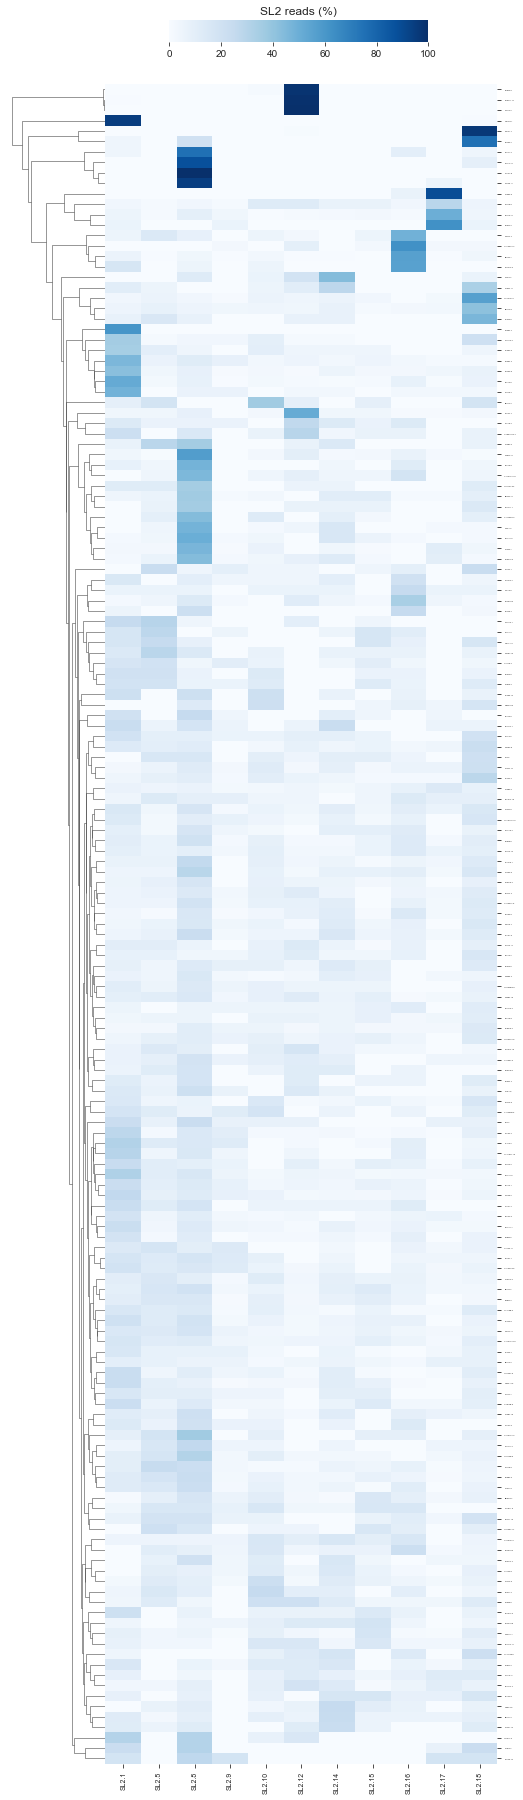

In [26]:
%matplotlib inline

plt.figure(dpi=500)


# generate clustermap
_map = sns.color_palette("Blues", as_cmap=True)


cluster = sns.clustermap(sl1_filtered_percent, vmin=0, vmax=100, cmap=_map, figsize=(8,30), dendrogram_ratio=0.2, 
                         yticklabels=True, xticklabels=True, col_cluster=False, 
                         cbar_kws={'orientation':'horizontal'}, cbar_pos=[0.3, 0.82, 0.45, 0.01])


# format y and x ticks to show all gene names
a = cluster.ax_heatmap.set_yticklabels(cluster.ax_heatmap.get_ymajorticklabels(), fontsize = 2)
b = cluster.ax_heatmap.set_xticklabels(cluster.ax_heatmap.get_xmajorticklabels(), fontsize = 7)

cluster.ax_cbar.set_title('SL2 reads (%)', fontsize=12)
cluster.ax_col_dendrogram.set_visible(False)

plt.savefig('Fig3.b-clustermap_SL1.pdf', dpi=800, bbox_inches='tight')

<font size="4">**Figure 3.b:**<br></font>
For SL1 trans spliced site represented in panel a (with more than 10 individual reads with an unambiguous SL2 sequence) we represent the frequency of usage of each SL2.<br>
**SL1 genes :** genes identified as preferentially SL1.

<br>